In [15]:
import os
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

In [17]:
API_KEY = os.getenv('NIXTLA_API_KEY')
if API_KEY:
    print('API key loaded successfully')
nixtla_client = NixtlaClient(api_key=API_KEY)
valid_api_key = nixtla_client.validate_api_key()

API key loaded successfully


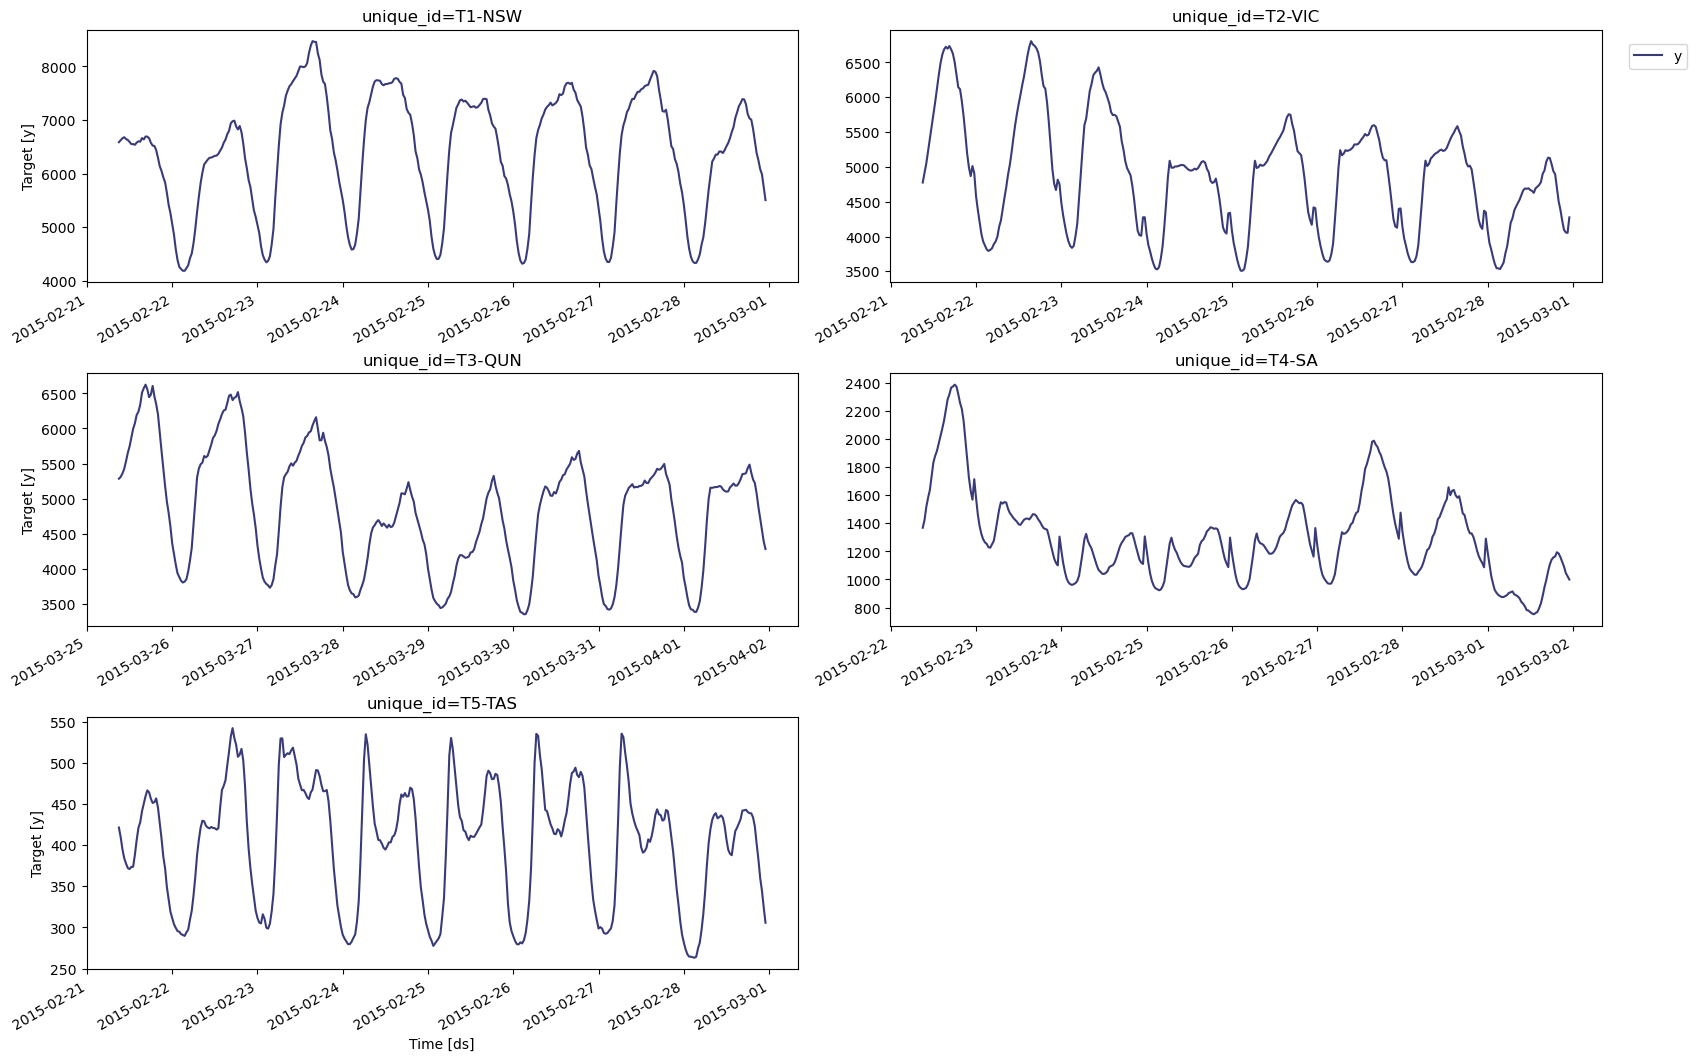

In [3]:
def read_tsf_from_url(url):
    data = []
    start_date = pd.to_datetime('2002-01-01 00:00:00')
    
    # Fetch the content from the URL
    response = requests.get(url)
    response.raise_for_status()

    # Process each line of the file
    for line in response.text.splitlines():
        if line.startswith('T'):
            parts = line.strip().split(':')
            unique_id = parts[0] + '-' + parts[1]
            values = list(map(float, parts[3].split(',')[:-1]))
            
            # Generate datetime index at half-hour intervals
            periods = len(values)
            date_range = pd.date_range(start=start_date, periods=periods, freq='30min')
            
            # Append to data list
            for dt, value in zip(date_range, values):
                data.append([unique_id, dt, value])

    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

url = 'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/australian_electricity_demand_dataset.tsf'
df = read_tsf_from_url(url)


df.groupby('unique_id').head(2)


nixtla_client.plot(
    df, 
    max_insample_length=365, 
)


In [5]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
230735,T2-VIC,2002-01-01 00:00:00,3535.867064
230736,T2-VIC,2002-01-01 00:30:00,3383.499028
461470,T3-QUN,2002-01-01 00:00:00,3382.041342
461471,T3-QUN,2002-01-01 00:30:00,3288.315794
693741,T4-SA,2002-01-01 00:00:00,1191.078014
693742,T4-SA,2002-01-01 00:30:00,1219.589472
924524,T5-TAS,2002-01-01 00:00:00,315.915504
924525,T5-TAS,2002-01-01 00:30:00,306.245864


In [7]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 2 days (96 * 0.5h *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)


C:\Users\ardahal\AppData\Local\Temp\ipykernel_30052\494663917.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)


In [8]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: 30min
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 6.351092338562012


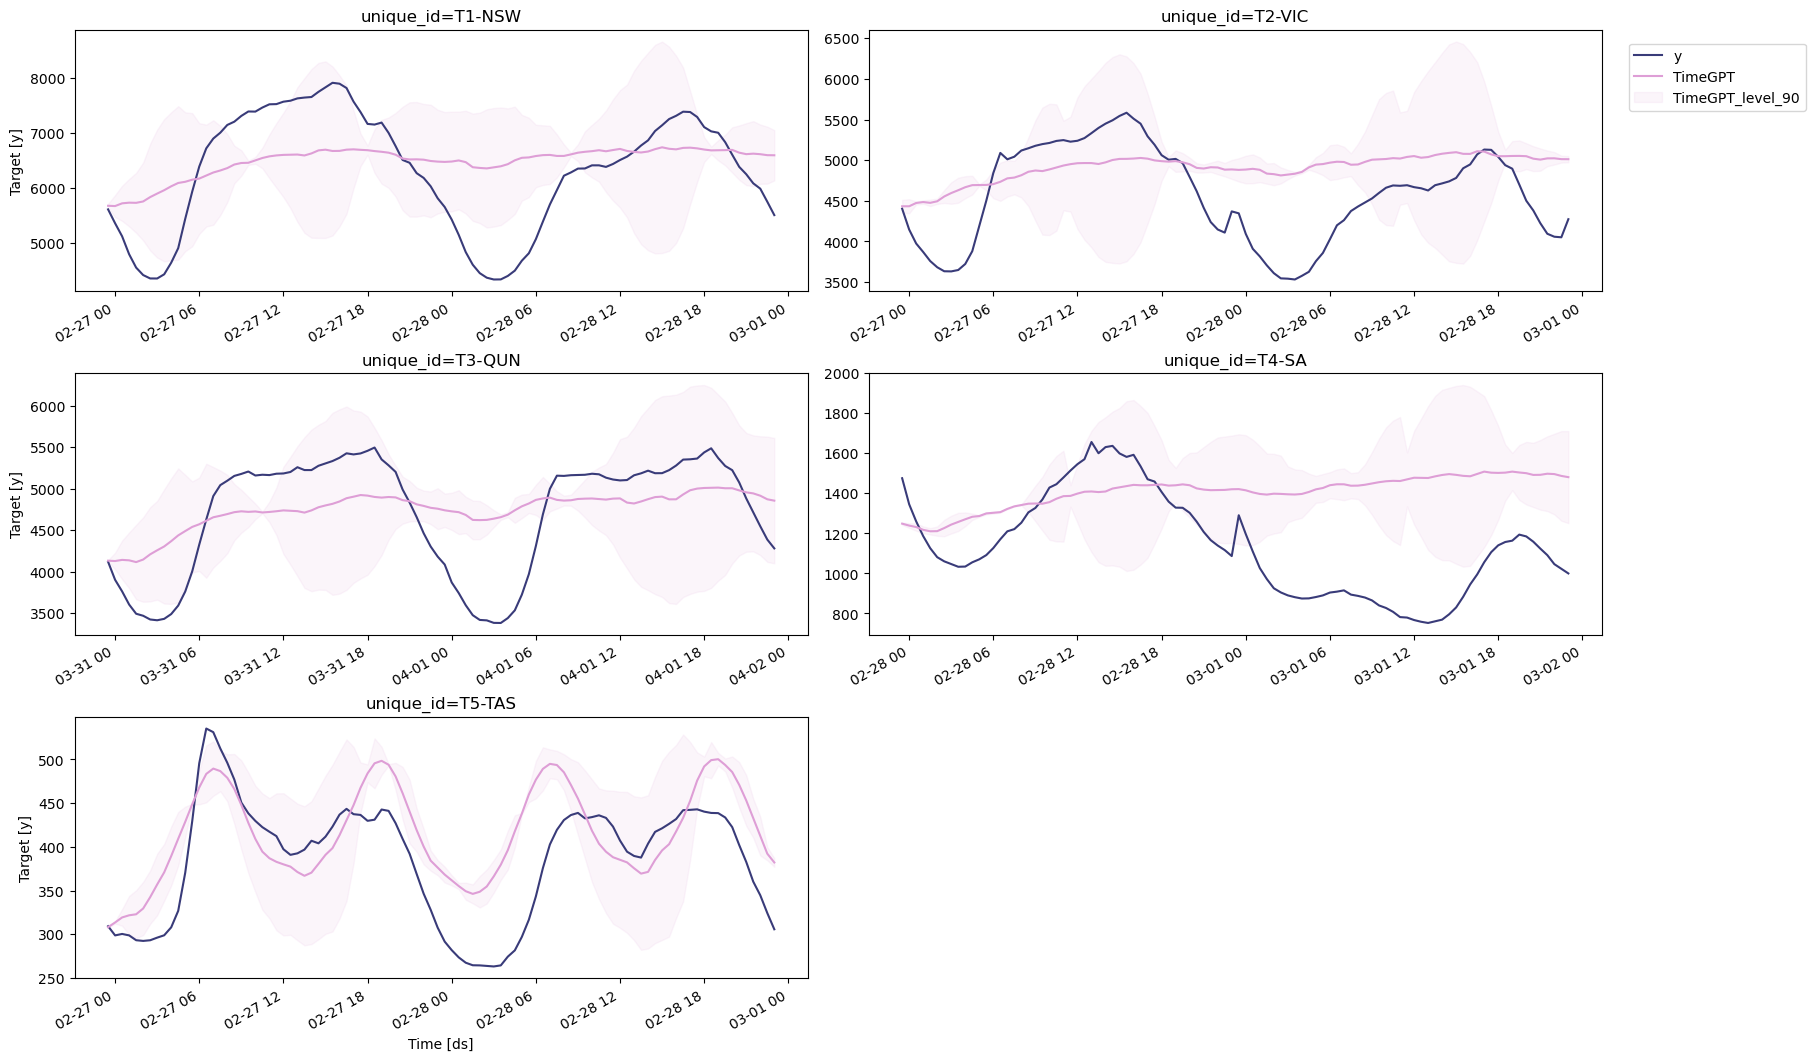

In [9]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')


In [10]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])


In [11]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics


metric
mae      436.799568
smape      0.075238
Name: TimeGPT, dtype: float64